In [ ]:
!pip install -U segmentation-models-pytorch -q

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
import os
import cv2
import sys
import glob
import shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from dataclasses import dataclass
from tqdm import tqdm,trange,tqdm_notebook
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

import torch, torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim


In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
@dataclass

class Config:
    maxsize: int = 224
    batch_size: int = 64
    lr: float = 1e-4


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### **LOAD DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
celeb_path = '/content/drive/MyDrive/Sorghum Disease Image Dataset/Rust'
segment_path = '/content/drive/MyDrive/Rust_mask'

def get_images(img_path, mask_path):
    img_files = os.listdir(img_path)
    mask_files = os.listdir(mask_path)

    img_names = {os.path.splitext(f)[0] for f in img_files}
    mask_names = {os.path.splitext(f)[0] for f in mask_files}

    matching_names = img_names.intersection(mask_names)
    matching_pairs = []
    print(matching_names)
    for name in matching_names:
        img_file = os.path.join(img_path, name + '.jpg')
        mask_file = os.path.join(mask_path, name + '.png')
        if os.path.exists(img_file) and os.path.exists(mask_file):
            matching_pairs.append((img_file, mask_file))
    return matching_pairs

In [ ]:
img_paths = get_images(celeb_path, segment_path)

img_fold = []
mask_fold = []

for i, m in img_paths:
    img_fold.append(i)
    mask_fold.append(m)

{'Rust300', 'Rust1794', 'Rust2343', 'Rust404', 'Rust1820', 'Rust609', 'Rust662', 'Rust2245', 'Rust1677', 'Rust502', 'Rust448', 'Rust1818', 'Rust8', 'Rust1634', 'Rust1511', 'Rust431', 'Rust2210', 'Rust210', 'Rust2115', 'Rust1688', 'Rust569', 'Rust79', 'Rust2204', 'Rust319', 'Rust1461', 'Rust465', 'Rust803', 'Rust1838', 'Rust1306', 'Rust391', 'Rust2053', 'Rust1539', 'Rust1003', 'Rust1812', 'Rust1836', 'Rust202', 'Rust422', 'Rust659', 'Rust1412', 'Rust2240', 'Rust1073', 'Rust1083', 'Rust1703', 'Rust1056', 'Rust1715', 'Rust1351', 'Rust190', 'Rust539', 'Rust593', 'Rust2127', 'Rust370', 'Rust566', 'Rust740', 'Rust1272', 'Rust2312', 'Rust1778', 'Rust550', 'Rust561', 'Rust595', 'Rust718', 'Rust1398', 'Rust1028', 'Rust1320', 'Rust1604', 'Rust440', 'Rust1780', 'Rust1996', 'Rust826', 'Rust1968', 'Rust608', 'Rust487', 'Rust2218', 'Rust2035', 'Rust1633', 'Rust1129', 'Rust1348', 'Rust152', 'Rust1763', 'Rust2185', 'Rust393', 'Rust2316', 'Rust1067', 'Rust213', 'Rust1411', 'Rust580', 'Rust1038', 'Rust1

### **PREPROCESS**

In [ ]:
data_transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.Resize(256,256),
    A.OneOf(
        [
            A.Sharpen(alpha = (0.1, 0.2), lightness = (0.1, 0.2), p = 0.3),
            A.Blur(blur_limit = [1,3], p=0.3),
            A.GaussNoise(var_limit = (1,5), p = 0.3)
        ]
    ),
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [ ]:
test_transform = A.Compose([
    A.Resize(256,256),
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [ ]:
class Dataset(Dataset):
    def __init__(self, img_paths, mask_paths, input_transform = None):

        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = input_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        mask = np.array(mask)
        binary_mask = np.where(mask == 255, 1, 0)

        if self.transform:
            augmented = self.transform(image=np.array(image), mask = binary_mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)

In [ ]:
dataset = Dataset(img_fold, mask_fold, input_transform=data_transform)

In [ ]:
dataset

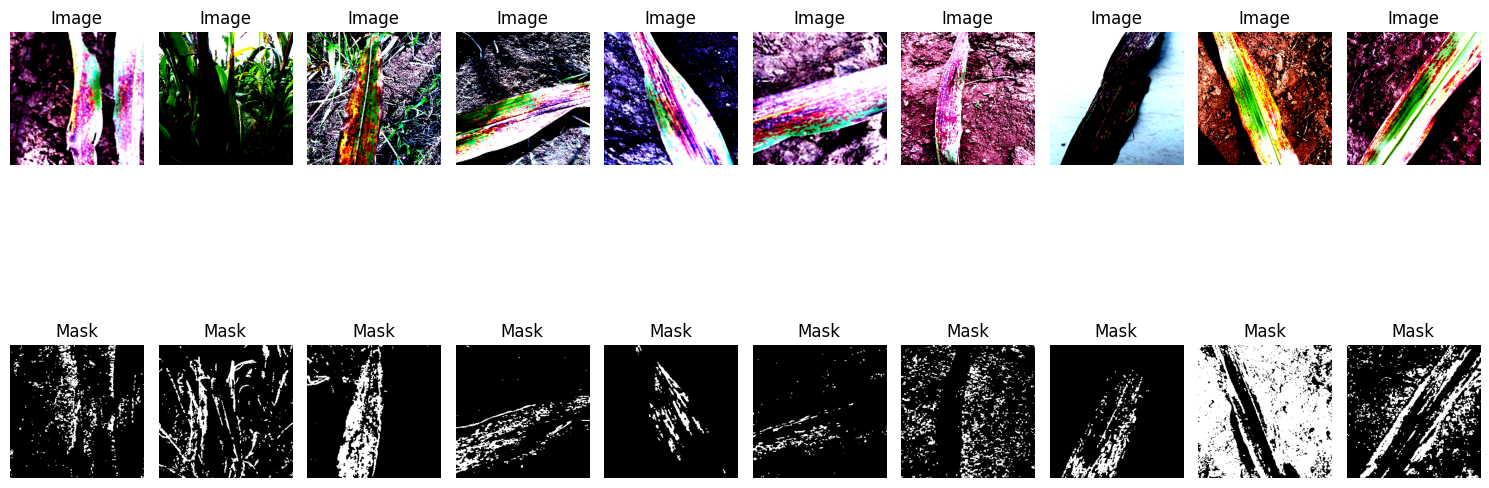

In [ ]:
def visualize_samples(dataset, num_samples=5):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=num_samples, shuffle=True)
    images, masks = next(iter(dataloader))


    images = images.numpy()
    if images.shape[1] == 3:

        images = images.transpose(0, 2, 3, 1)
    elif images.shape[1] == 1:
        images = images.squeeze(1)

    masks = masks.numpy()
    masks = masks.squeeze(1)


    plt.figure(figsize=(15, 8))
    for idx in range(num_samples):
        plt.subplot(2, num_samples, idx + 1)
        plt.imshow(images[idx])
        plt.axis('off')
        plt.title('Image')

        plt.subplot(2, num_samples, idx + 1 + num_samples)
        plt.imshow(masks[idx], cmap='gray')
        plt.axis('off')
        plt.title('Mask')

    plt.tight_layout()
    plt.show()


visualize_samples(dataset, num_samples=10)

In [ ]:
dataloader = DataLoader(dataset, batch_size = Config.batch_size, pin_memory=True, drop_last=True)

### **LOAD MODEL**

In [ ]:
model = smp.Unet(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    activation = 'sigmoid',
    classes = 1,
    in_channels = 3
)

In [ ]:
model = smp.Unet(
    encoder_name='resnet34',
    encoder_weights=None,
    activation='sigmoid',
    classes=1,
    in_channels=3
)

In [ ]:
criterion = utils.losses.DiceLoss()
optimizer = optim.AdamW(model.parameters(), lr = Config.lr)

metrics = [
    utils.metrics.Fscore(),
    utils.metrics.IoU()
]

In [ ]:
train_epoch = utils.train.TrainEpoch(
    model,
    loss=criterion,
    metrics = metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

### **TRAINING**

In [ ]:
max_score = 0
num_epochs = 10

loss_logs = {"Loss": []}
metric_logs = {"Metrics": []}

for i in range(num_epochs):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(dataloader)
    train_loss, train_metric, train_metric_IOU = list(train_logs.values())
    loss_logs["Loss"].append(train_loss)
    metric_logs["Metrics"].append(train_metric_IOU)

    print('Train - Epoch {}, Loss: {:.4f}, IOU: {:.4f}'.format(i, train_loss, train_metric_IOU))

    if train_metric_IOU > max_score:
        max_score = train_metric_IOU
        torch.save(model.state_dict(), '/content/drive/MyDrive/UNet model/best_model2.pth')


Epoch: 0
train: 100%|██████████| 34/34 [13:05<00:00, 23.09s/it, dice_loss - 0.5912, fscore - 0.4934, iou_score - 0.3316]
Train - Epoch 0, Loss: 0.5912, IOU: 0.3316

Epoch: 1
train: 100%|██████████| 34/34 [01:20<00:00,  2.36s/it, dice_loss - 0.4767, fscore - 0.6305, iou_score - 0.462]
Train - Epoch 1, Loss: 0.4767, IOU: 0.4620

Epoch: 2
train: 100%|██████████| 34/34 [01:19<00:00,  2.35s/it, dice_loss - 0.4205, fscore - 0.6891, iou_score - 0.5271]
Train - Epoch 2, Loss: 0.4205, IOU: 0.5271

Epoch: 3
train: 100%|██████████| 34/34 [01:19<00:00,  2.33s/it, dice_loss - 0.3871, fscore - 0.7163, iou_score - 0.5592]
Train - Epoch 3, Loss: 0.3871, IOU: 0.5592

Epoch: 4
train: 100%|██████████| 34/34 [01:20<00:00,  2.36s/it, dice_loss - 0.3606, fscore - 0.736, iou_score - 0.5833]
Train - Epoch 4, Loss: 0.3606, IOU: 0.5833

Epoch: 5
train: 100%|██████████| 34/34 [01:20<00:00,  2.38s/it, dice_loss - 0.3387, fscore - 0.751, iou_score - 0.6022]
Train - Epoch 5, Loss: 0.3387, IOU: 0.6022

Epoch: 6
tra

In [ ]:
def denormalize(image):
    mean_tensor = torch.tensor(mean, device=image.device).view(1, 3, 1, 1)
    std_tensor = torch.tensor(std, device=image.device).view(1, 3, 1, 1)
    return image * std_tensor + mean_tensor

In [ ]:
def visualize_predictions(image, mask, prediction):
    image = denormalize(image).squeeze(0)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image.permute(1, 2, 0).cpu().numpy())
    axes[0].set_title('Image')

    axes[1].imshow(mask.squeeze(0).cpu().numpy(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')

    axes[2].imshow(prediction.squeeze(0).cpu().numpy(), cmap='gray')
    axes[2].set_title('Predicted Mask')

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# model.load_state_dict(torch.load('/kaggle/input/facebest/facebest.pth'))
# model.to(device)
# model.eval()

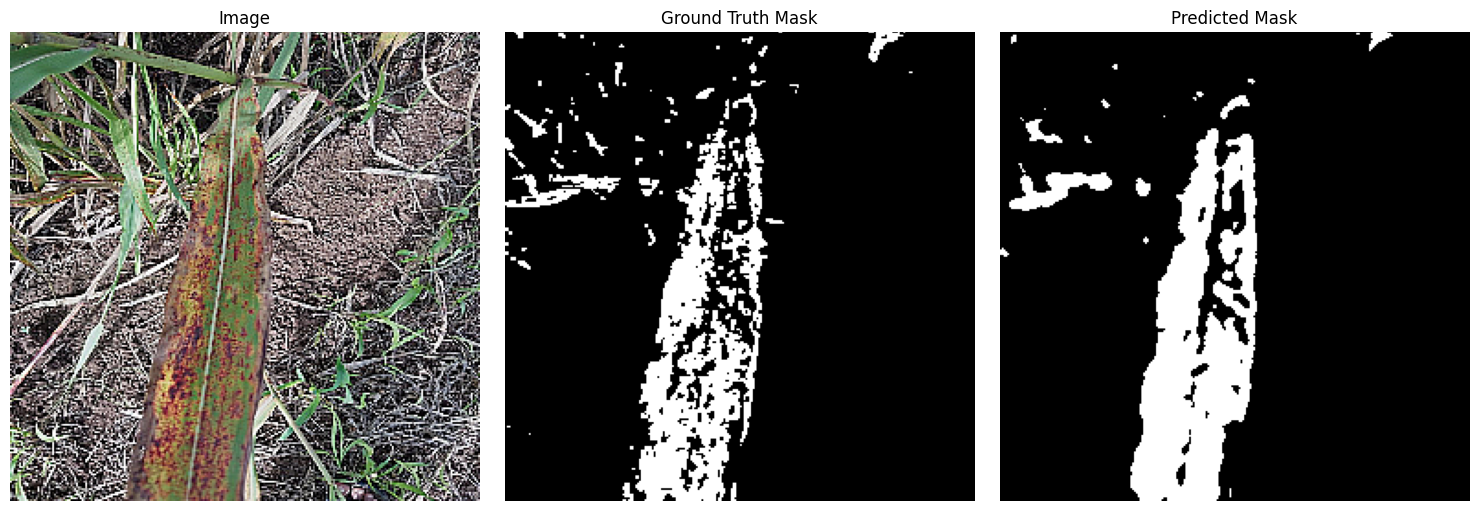

In [ ]:
for images, masks in dataloader:
    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        predictions = model(images)
        predictions = (predictions > 0.5).float()

    visualize_predictions(images[62], masks[62], predictions[62])
    break

### **TESTING**

In [ ]:
def generation(image_path, model):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    input_tensor = transform(image).unsqueeze(0)
    model.eval()
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        predictions = model(input_tensor)
        predictions = (predictions > 0.5).float()

    input_image = denormalize(input_tensor).squeeze(0).permute(1, 2, 0).cpu().numpy()
    predicted_mask = predictions.squeeze(0).squeeze(0).cpu().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(input_image)
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
test_img_path = '/content/jowar.jpg'

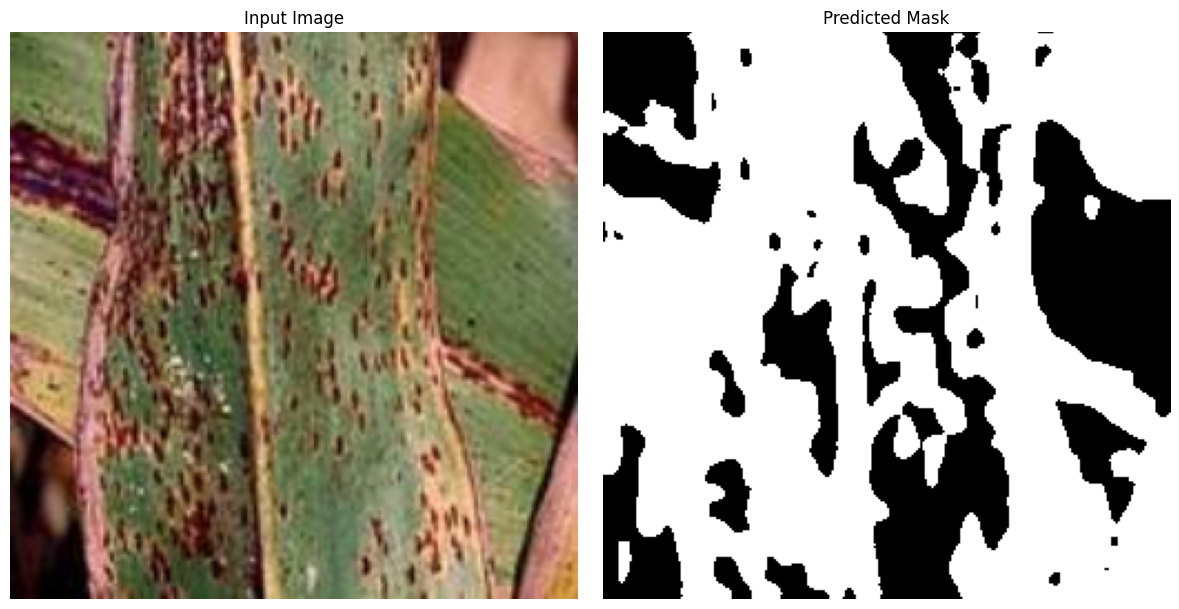

In [ ]:
generation(test_img_path, model)

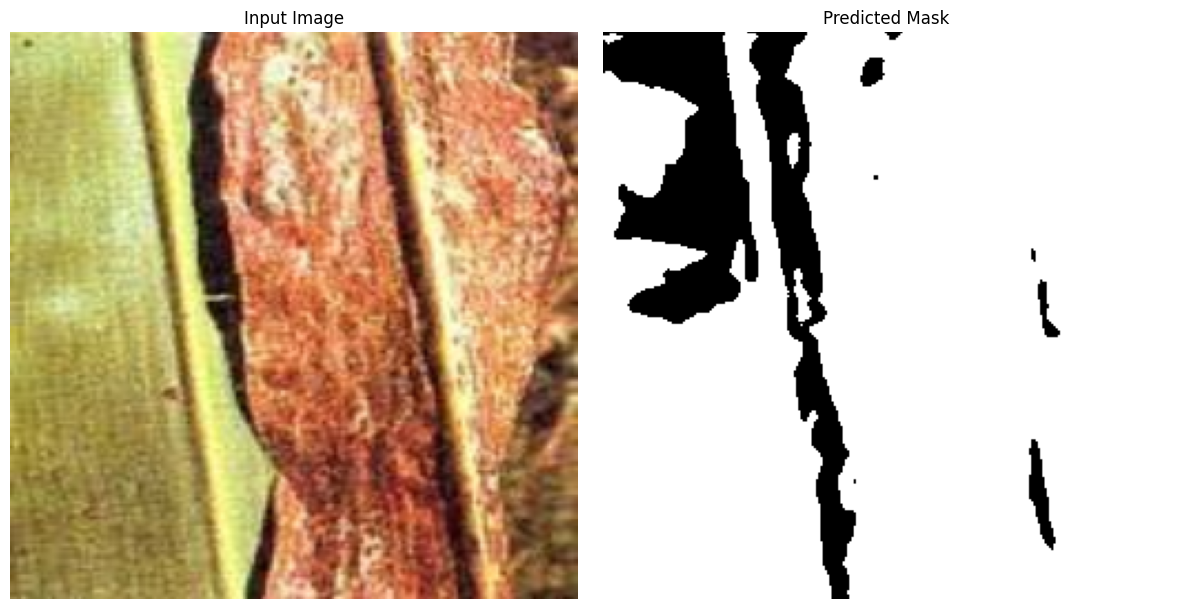

In [ ]:
test2 = "/content/Rust1.jpg"
generation(test2, model)

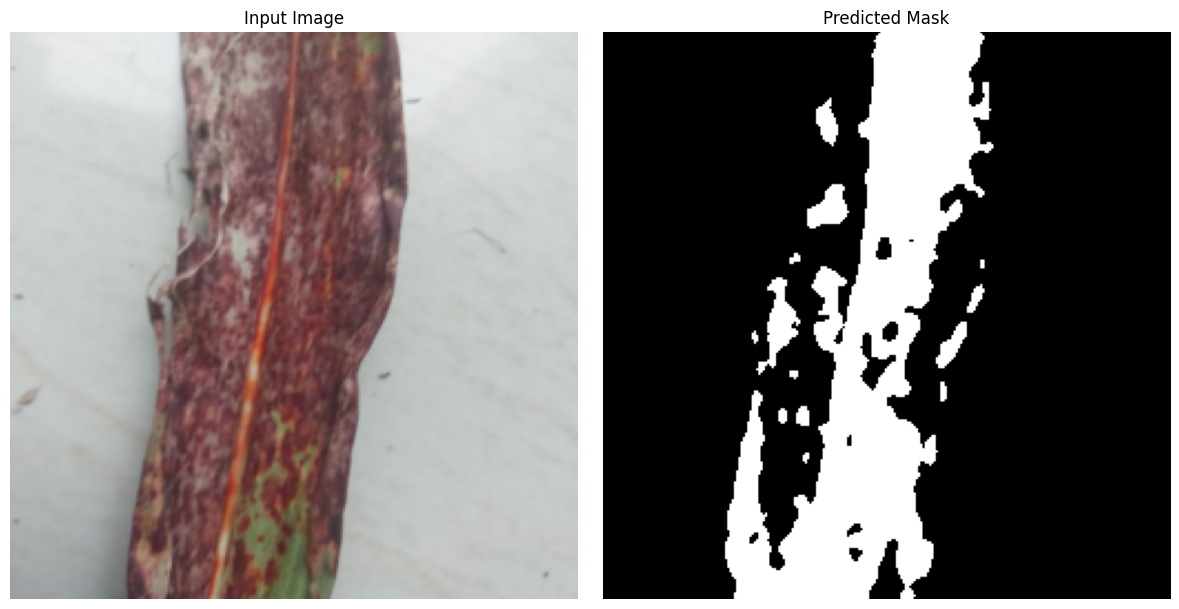

In [ ]:
test3 = "/content/Rust2263.jpg"
generation(test3, model)